In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import seaborn as sns
sns.set()

In [2]:
!dir

 Volume in drive D has no label.
 Volume Serial Number is 3417-05D0

 Directory of D:\PythonTraining\Signate\AI Quest アセスメント

2020/08/18  21:04    <DIR>          .
2020/08/18  21:04    <DIR>          ..
2020/08/18  20:15    <DIR>          .ipynb_checkpoints
2020/08/18  21:04           198,432 20200818_01.ipynb
2020/08/17  19:55           155,642 sample_submit.csv
2020/08/17  19:55        24,919,869 test.csv
2020/08/17  19:55        75,690,186 train.csv
               4 File(s)    100,964,129 bytes
               3 Dir(s)  957,337,010,176 bytes free


In [3]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
submit = pd.read_csv('sample_submit.csv', header=None)
train.shape, test.shape, submit.shape

((55583, 28), (18528, 27), (18528, 2))

In [4]:
train.head()

,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
id,,,,,,,,,,,,,,,,,,,,,
0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,...,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0
1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,...,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0
2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,...,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,65.0
3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,...,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133,166.0
4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,...,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0


In [5]:
submit.head()

,0,1
0,0,10
1,1,10
2,2,10
3,3,10
4,4,10


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55583 entries, 0 to 55582
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accommodates            55583 non-null  int64  
 1   amenities               55583 non-null  object 
 2   bathrooms               55436 non-null  float64
 3   bed_type                55583 non-null  object 
 4   bedrooms                55512 non-null  float64
 5   beds                    55487 non-null  float64
 6   cancellation_policy     55583 non-null  object 
 7   city                    55583 non-null  object 
 8   cleaning_fee            55583 non-null  object 
 9   description             55583 non-null  object 
 10  first_review            43675 non-null  object 
 11  host_has_profile_pic    55435 non-null  object 
 12  host_identity_verified  55435 non-null  object 
 13  host_response_rate      41879 non-null  object 
 14  host_since              55435 non-null

In [7]:
cols_o = train.select_dtypes(include='object').columns.tolist()
cols_o

['amenities',
 'bed_type',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'description',
 'first_review',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_response_rate',
 'host_since',
 'instant_bookable',
 'last_review',
 'name',
 'neighbourhood',
 'property_type',
 'room_type',
 'thumbnail_url',
 'zipcode']

In [8]:
test['y'] = -999

In [9]:
all_df = pd.concat([train, test])

In [10]:
for col in cols_o:
    print('==', col, all_df[col].nunique())
    print(all_df[col].value_counts())

== amenities 67122
{}                                                                                                                                                                                                                                                                                                                                                                        586
{"translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}                                                                                                                                                                                                                                                                               135
{"Family/kid friendly"}                                                                                                                                                                                                                                  

== room_type 3
Entire home/apt    41310
Private room       30638
Shared room         2163
Name: room_type, dtype: int64
== thumbnail_url 65883
https://a0.muscache.com/im/pictures/70087089/bc66229a_original.jpg?aki_policy=small              3
https://a0.muscache.com/im/pictures/104667326/a7a2b145_original.jpg?aki_policy=small             2
https://a0.muscache.com/im/pictures/4491e5c5-33f6-4704-9887-76a059f86fda.jpg?aki_policy=small    2
https://a0.muscache.com/im/pictures/28563531/1000de61_original.jpg?aki_policy=small              2
https://a0.muscache.com/im/pictures/61042471/5543b0e0_original.jpg?aki_policy=small              2
                                                                                                ..
https://a0.muscache.com/im/pictures/990088e5-c861-44a6-b741-b06243e37c58.jpg?aki_policy=small    1
https://a0.muscache.com/im/pictures/db52b526-f161-4744-a428-fbfef7f5372e.jpg?aki_policy=small    1
https://a0.muscache.com/im/pictures/2e789b41-d4fb-4f76-97ca-5b58d

In [ ]:
all_df['last_review'] = all_df['last_review'].fillna('9999-99-99')
all_df['first_review'] = all_df['first_review'].fillna('9999-99-99')
all_df['host_since'] = all_df['host_since'].fillna('9999-99-99')


In [11]:
all_df['last_review'] = pd.to_datetime(all_df['last_review'], format='%Y-%m-%d')
all_df['first_review'] = pd.to_datetime(all_df['first_review'], format='%Y-%m-%d')
all_df['host_since'] = pd.to_datetime(all_df['host_since'], format='%Y-%m-%d')

In [12]:
all_df['host_response_rate'].apply(lambda x: x)

id
0         NaN
1        100%
2        100%
3        100%
4        100%
         ... 
18523    100%
18524    100%
18525    100%
18526    100%
18527    100%
Name: host_response_rate, Length: 74111, dtype: object

In [13]:
all_df.isnull().sum()

accommodates                  0
amenities                     0
bathrooms                   200
bed_type                      0
bedrooms                     91
beds                        131
cancellation_policy           0
city                          0
cleaning_fee                  0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
property_type                 0
review_scores_rating      16722
room_type                     0
thumbnail_url              8216
zipcode                     966
y                             0
dtype: int64

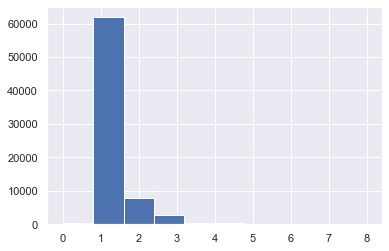

In [14]:
all_df['bathrooms'].hist()

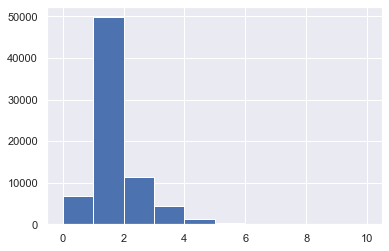

In [15]:
all_df['bedrooms'].hist()

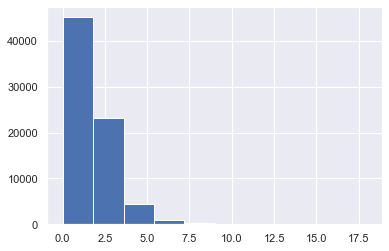

In [16]:
all_df['beds'].hist()

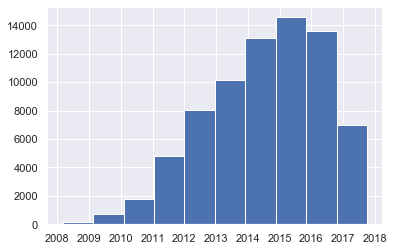

In [17]:
all_df['host_since'].hist()

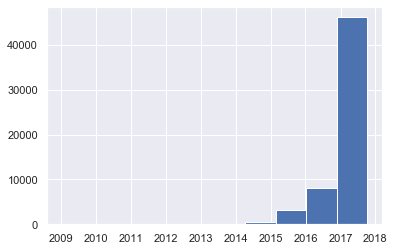

In [18]:
all_df['last_review'].hist()

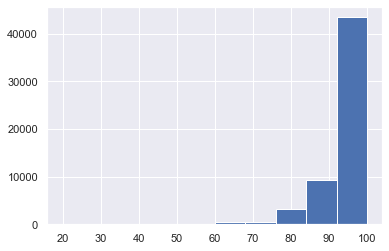

In [19]:
all_df['review_scores_rating'].hist()

In [79]:
all_df['last_review'], all_df['host_since']

(id
 0       2016-07-27
 1       2017-03-31
 2       2017-08-13
 3       2017-09-03
 4       2017-09-10
            ...    
 18523          NaT
 18524   2017-04-11
 18525          NaT
 18526   2017-05-08
 18527   2017-01-24
 Name: last_review, Length: 74111, dtype: datetime64[ns],
 id
 0       2016-07-13
 1       2015-12-30
 2       2016-05-21
 3       2012-06-19
 4       2015-03-25
            ...    
 18523   2009-11-16
 18524   2017-01-08
 18525   2014-09-02
 18526   2014-03-17
 18527   2015-08-19
 Name: host_since, Length: 74111, dtype: datetime64[ns])

In [20]:
all_df['host_response_rate'] = all_df['host_response_rate'].fillna(-1)
all_df['host_response_rate'] = all_df['host_response_rate'].apply(lambda x: x if x != '' else -1)
all_df['host_response_rate']

id
0          -1
1        100%
2        100%
3        100%
4        100%
         ... 
18523    100%
18524    100%
18525    100%
18526    100%
18527    100%
Name: host_response_rate, Length: 74111, dtype: object

In [21]:
all_df['host_response_rate'] =all_df['host_response_rate'].apply(lambda x: x if x == -1 else x[:-1])
all_df['host_response_rate']

id
0         -1
1        100
2        100
3        100
4        100
        ... 
18523    100
18524    100
18525    100
18526    100
18527    100
Name: host_response_rate, Length: 74111, dtype: object

In [22]:
all_df['host_response_rate'].value_counts()

100    43254
-1     18299
90      2277
80      1113
0        883
       ...  
15         1
6          1
31         1
21         1
39         1
Name: host_response_rate, Length: 81, dtype: int64

In [23]:
all_df['zipcode'] = all_df['zipcode'].str[:5]
all_df['zipcode'] = all_df['zipcode'].fillna(99999)
all_df['zipcode']

id
0        90804
1        20018
2        99999
3        94133
4        10024
         ...  
18523    11222
18524    60657
18525    60618
18526    10029
18527    90027
Name: zipcode, Length: 74111, dtype: object

In [24]:
all_df.isnull().sum()

accommodates                  0
amenities                     0
bathrooms                   200
bed_type                      0
bedrooms                     91
beds                        131
cancellation_policy           0
city                          0
cleaning_fee                  0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate            0
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
property_type                 0
review_scores_rating      16722
room_type                     0
thumbnail_url              8216
zipcode                       0
y                             0
dtype: int64

In [25]:
aa = pd.DataFrame(all_df.isnull().sum())

In [26]:
ab  = aa[aa[0] == 0]

In [27]:
ab = ab.index.tolist()

In [28]:
ab

['accommodates',
 'amenities',
 'bed_type',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'description',
 'host_response_rate',
 'instant_bookable',
 'latitude',
 'longitude',
 'name',
 'number_of_reviews',
 'property_type',
 'room_type',
 'zipcode',
 'y']

In [29]:
all_df[ab]

,accommodates,amenities,bed_type,cancellation_policy,city,cleaning_fee,description,host_response_rate,instant_bookable,latitude,longitude,name,number_of_reviews,property_type,room_type,zipcode,y
id,,,,,,,,,,,,,,,,,
0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",Real Bed,flexible,LA,t,My place is meant for family and a few friends...,-1,f,33.788931,-118.154761,The Penthouse,1,Apartment,Private room,90804,138.0
1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",Real Bed,strict,DC,t,This is a new listing for a lovely guest bedro...,100,f,38.934810,-76.978190,Guest Bedroom in Brookland,9,House,Private room,20018,42.0
2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",Real Bed,strict,NYC,t,We're looking forward to your stay at our apt....,100,t,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,27,Apartment,Private room,99999,65.0
3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",Real Bed,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,100,t,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,38,Apartment,Private room,94133,166.0
4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",Real Bed,strict,NYC,t,Charming Apartment on the upper west side of M...,100,f,40.785050,-73.974691,Charming 1-bedroom - UWS Manhattan,5,Apartment,Entire home/apt,10024,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,4,"{TV,Internet,""Wireless Internet"",""Air conditio...",Real Bed,strict,NYC,t,"The Greenhouse, located on Green Street, is a ...",100,f,40.734555,-73.954892,Spacious 2BR Greenpoint Getaway,0,Apartment,Entire home/apt,11222,-999.0
18524,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",Real Bed,flexible,Chicago,f,"Two bedroom, one bathroom with large dining/li...",100,f,41.945939,-87.672018,Walk up Apartment in Lakeview/Wrigleyville,9,Apartment,Entire home/apt,60657,-999.0
18525,5,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",Real Bed,flexible,Chicago,t,Happy Holidays! If you're looking for a big op...,100,f,41.933123,-87.708087,Beautiful Logan Square Home,0,House,Entire home/apt,60618,-999.0


In [30]:
ab = [
 'bed_type',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'instant_bookable',
 'property_type',
 'room_type',
]

In [31]:
all_df[ab]

,bed_type,cancellation_policy,city,cleaning_fee,instant_bookable,property_type,room_type
id,,,,,,,
0,Real Bed,flexible,LA,t,f,Apartment,Private room
1,Real Bed,strict,DC,t,f,House,Private room
2,Real Bed,strict,NYC,t,t,Apartment,Private room
3,Real Bed,strict,SF,t,t,Apartment,Private room
4,Real Bed,strict,NYC,t,f,Apartment,Entire home/apt
...,...,...,...,...,...,...,...
18523,Real Bed,strict,NYC,t,f,Apartment,Entire home/apt
18524,Real Bed,flexible,Chicago,f,f,Apartment,Entire home/apt
18525,Real Bed,flexible,Chicago,t,f,House,Entire home/apt


In [32]:
from sklearn import preprocessing

In [33]:
for column in ab:
    le = preprocessing.LabelEncoder()
    le.fit(all_df[column])
    all_df[column] = le.transform(all_df[column])

In [34]:
ac = ['accommodates',
 'amenities',
 'bed_type',
 'cancellation_policy',
 'city',
 'cleaning_fee',
#  'description',
 'host_response_rate',
 'instant_bookable',
 'latitude',
 'longitude',
#  'name',
 'number_of_reviews',
 'property_type',
 'room_type',
 'zipcode',
 'y']

In [35]:
all_df2 = all_df[ac]
all_df2

,accommodates,amenities,bed_type,cancellation_policy,city,cleaning_fee,host_response_rate,instant_bookable,latitude,longitude,number_of_reviews,property_type,room_type,zipcode,y
id,,,,,,,,,,,,,,,
0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",4,0,3,1,-1,0,33.788931,-118.154761,1,0,1,90804,138.0
1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,2,2,1,100,0,38.934810,-76.978190,9,17,1,20018,42.0
2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",4,2,4,1,100,1,40.695118,-73.926240,27,0,1,99999,65.0
3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,2,5,1,100,1,37.796728,-122.411906,38,0,1,94133,166.0
4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",4,2,4,1,100,0,40.785050,-73.974691,5,0,0,10024,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,4,"{TV,Internet,""Wireless Internet"",""Air conditio...",4,2,4,1,100,0,40.734555,-73.954892,0,0,0,11222,-999.0
18524,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",4,0,1,0,100,0,41.945939,-87.672018,9,0,0,60657,-999.0
18525,5,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",4,0,1,1,100,0,41.933123,-87.708087,0,17,0,60618,-999.0


In [36]:
all_df2[['amenities']].values

array([['{TV,"Wireless Internet",Kitchen,"Free parking on premises",Washer,Dryer,"Smoke detector"}'],
       ['{TV,"Cable TV",Internet,"Wireless Internet","Air conditioning",Kitchen,"Free parking on premises",Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit",Essentials,Shampoo,"Lock on bedroom door","24-hour check-in",Hangers,Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}'],
       ['{TV,Internet,"Wireless Internet",Kitchen,"Indoor fireplace","Buzzer/wireless intercom",Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door","24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Self Check-In",Keypad,Lockbox,Bathtub,"Room-darkening shades"}'],
       ...,
       ['{TV,"Wirel

In [37]:
for amenity in all_df2[['amenities']].values:
    for _amt in amenity[0][1:-1].split(','):
        all_df2[_amt] = 1


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
all_df2

,accommodates,amenities,bed_type,cancellation_policy,city,cleaning_fee,host_response_rate,instant_bookable,latitude,longitude,...,"""Flat smooth pathway to front door""","""Body soap""","""Hand soap""","""Bath towel""","""Hand or paper towel""","""Toilet paper""","""Grab-rails for shower and toilet""","""Paid parking off premises""","""Roll-in shower with chair""","""Wide clearance to shower and toilet"""
id,,,,,,,,,,,,,,,,,,,,,
0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",4,0,3,1,-1,0,33.788931,-118.154761,...,1,1,1,1,1,1,1,1,1,1
1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,2,2,1,100,0,38.934810,-76.978190,...,1,1,1,1,1,1,1,1,1,1
2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",4,2,4,1,100,1,40.695118,-73.926240,...,1,1,1,1,1,1,1,1,1,1
3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,2,5,1,100,1,37.796728,-122.411906,...,1,1,1,1,1,1,1,1,1,1
4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",4,2,4,1,100,0,40.785050,-73.974691,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,4,"{TV,Internet,""Wireless Internet"",""Air conditio...",4,2,4,1,100,0,40.734555,-73.954892,...,1,1,1,1,1,1,1,1,1,1
18524,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",4,0,1,0,100,0,41.945939,-87.672018,...,1,1,1,1,1,1,1,1,1,1
18525,5,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",4,0,1,1,100,0,41.933123,-87.708087,...,1,1,1,1,1,1,1,1,1,1


In [39]:
all_df2.columns

Index(['accommodates', 'amenities', 'bed_type', 'cancellation_policy', 'city',
       'cleaning_fee', 'host_response_rate', 'instant_bookable', 'latitude',
       'longitude',
       ...
       '"Flat smooth pathway to front door"', '"Body soap"', '"Hand soap"',
       '"Bath towel"', '"Hand or paper towel"', '"Toilet paper"',
       '"Grab-rails for shower and toilet"', '"Paid parking off premises"',
       '"Roll-in shower with chair"', '"Wide clearance to shower and toilet"'],
      dtype='object', length=146)

In [40]:
def int_value(x):
    try:
        return int(x)
    except ValueError:
        return 99999

In [41]:
all_df2['zipcode'] = all_df2['zipcode'].apply(int_value)

In [42]:
all_df2['host_response_rate'] = all_df2['host_response_rate'].astype('int')
all_df2['zipcode'] = all_df2['zipcode'].astype('int')

In [43]:
# all_df3 = all_df2.copy()
# all_df3

,accommodates,amenities,bed_type,cancellation_policy,city,cleaning_fee,host_response_rate,instant_bookable,latitude,longitude,...,"""Flat smooth pathway to front door""","""Body soap""","""Hand soap""","""Bath towel""","""Hand or paper towel""","""Toilet paper""","""Grab-rails for shower and toilet""","""Paid parking off premises""","""Roll-in shower with chair""","""Wide clearance to shower and toilet"""
id,,,,,,,,,,,,,,,,,,,,,
0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",4,0,3,1,-1,0,33.788931,-118.154761,...,1,1,1,1,1,1,1,1,1,1
1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,2,2,1,100,0,38.934810,-76.978190,...,1,1,1,1,1,1,1,1,1,1
2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",4,2,4,1,100,1,40.695118,-73.926240,...,1,1,1,1,1,1,1,1,1,1
3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,2,5,1,100,1,37.796728,-122.411906,...,1,1,1,1,1,1,1,1,1,1
4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",4,2,4,1,100,0,40.785050,-73.974691,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,4,"{TV,Internet,""Wireless Internet"",""Air conditio...",4,2,4,1,100,0,40.734555,-73.954892,...,1,1,1,1,1,1,1,1,1,1
18524,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",4,0,1,0,100,0,41.945939,-87.672018,...,1,1,1,1,1,1,1,1,1,1
18525,5,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",4,0,1,1,100,0,41.933123,-87.708087,...,1,1,1,1,1,1,1,1,1,1


In [44]:
# len(all_df3.columns)

146

In [45]:
# all_df3.columns = list(range(len(all_df3.columns)))
# all_df3

,0,1,2,3,4,5,6,7,8,9,...,136,137,138,139,140,141,142,143,144,145
id,,,,,,,,,,,,,,,,,,,,,
0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",4,0,3,1,-1,0,33.788931,-118.154761,...,1,1,1,1,1,1,1,1,1,1
1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,2,2,1,100,0,38.934810,-76.978190,...,1,1,1,1,1,1,1,1,1,1
2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",4,2,4,1,100,1,40.695118,-73.926240,...,1,1,1,1,1,1,1,1,1,1
3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,2,5,1,100,1,37.796728,-122.411906,...,1,1,1,1,1,1,1,1,1,1
4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",4,2,4,1,100,0,40.785050,-73.974691,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,4,"{TV,Internet,""Wireless Internet"",""Air conditio...",4,2,4,1,100,0,40.734555,-73.954892,...,1,1,1,1,1,1,1,1,1,1
18524,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",4,0,1,0,100,0,41.945939,-87.672018,...,1,1,1,1,1,1,1,1,1,1
18525,5,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",4,0,1,1,100,0,41.933123,-87.708087,...,1,1,1,1,1,1,1,1,1,1


## Training

In [46]:
X = all_df2[all_df2['y'] != -999].drop(['y', 'amenities'], axis=1)
y = all_df2[all_df2['y'] != -999]['y']

In [52]:
X.columns = list(range(len(X.columns)))
X

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
id,,,,,,,,,,,,,,,,,,,,,
0,6,4,0,3,1,-1,0,33.788931,-118.154761,1,...,1,1,1,1,1,1,1,1,1,1
1,2,4,2,2,1,100,0,38.934810,-76.978190,9,...,1,1,1,1,1,1,1,1,1,1
2,2,4,2,4,1,100,1,40.695118,-73.926240,27,...,1,1,1,1,1,1,1,1,1,1
3,2,4,2,5,1,100,1,37.796728,-122.411906,38,...,1,1,1,1,1,1,1,1,1,1
4,2,4,2,4,1,100,0,40.785050,-73.974691,5,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,4,4,2,4,1,100,0,40.739261,-73.994814,110,...,1,1,1,1,1,1,1,1,1,1
55579,2,4,1,1,0,-1,0,41.933710,-87.720810,6,...,1,1,1,1,1,1,1,1,1,1
55580,2,4,0,5,1,-1,0,37.762222,-122.416493,14,...,1,1,1,1,1,1,1,1,1,1


In [53]:
params = {'max_depth': list(range(2, 10)), 'random_state': [0], 'n_estimators': list(range(50, 200, 50))}

In [54]:
# LightGBM
lgb = LGBMRegressor()

reg_cv = GridSearchCV(lgb, params, cv=5, return_train_score=True)
reg_cv.fit(X, y)

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [50, 100, 150], 'random_state': [0]},
             return_train_score=True)

In [55]:
reg_cv.best_params_
# {'max_depth': 8, 'n_estimators': 150, 'random_state': 0}

{'max_depth': 8, 'n_estimators': 150, 'random_state': 0}

In [58]:
y_pred = reg_cv.predict(X)
y_pred

array([147.77625485,  63.09302767,  64.59586858, ..., 119.1472193 ,
        53.79095383,  67.77210553])

In [59]:
from sklearn.metrics import mean_squared_error

In [60]:
# RMSE を計算する
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(rmse)
# 102.5485062396882

102.5485062396882


## predict

In [61]:
X_test = all_df2[all_df2['y'] == -999].drop(['y', 'amenities'], axis=1)

In [62]:
y_pred = reg_cv.predict(X_test)

In [63]:
submit

,0,1
0,0,10
1,1,10
2,2,10
3,3,10
4,4,10
...,...,...
18523,18523,10
18524,18524,10
18525,18525,10
18526,18526,10


In [64]:
submit[1] = y_pred
submit

,0,1
0,0,297.864691
1,1,141.124685
2,2,111.291455
3,3,196.137069
4,4,140.876060
...,...,...
18523,18523,213.896267
18524,18524,115.564164
18525,18525,284.723350
18526,18526,136.906123


In [66]:
submit.to_csv('submit_20200818.csv', index=None, header=None)

## xgboost

In [68]:
# XGBoost
xgb = XGBRegressor()

reg_cv = GridSearchCV(xgb, params, cv=5, return_train_score=True)
reg_cv.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [69]:
reg_cv.best_params_
# {'max_depth': 5, 'n_estimators': 100, 'random_state': 0}

{'max_depth': 5, 'n_estimators': 100, 'random_state': 0}

In [70]:
y_pred = reg_cv.predict(X)
y_pred

array([188.03838 ,  52.727066,  61.477844, ..., 111.26565 ,  27.335587,
        75.43526 ], dtype=float32)

In [71]:
# RMSE を計算する
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(rmse)
# 99.19602883737033

99.19602883737033


## predict

In [73]:
X_test.columns = list(range(len(X_test.columns)))
X_test

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
id,,,,,,,,,,,,,,,,,,,,,
0,6,4,2,0,1,100,1,42.359278,-71.069962,58,...,1,1,1,1,1,1,1,1,1,1
1,3,4,1,3,1,100,0,34.084747,-118.367355,4,...,1,1,1,1,1,1,1,1,1,1
2,2,4,0,4,0,100,0,40.720541,-73.959192,0,...,1,1,1,1,1,1,1,1,1,1
3,4,4,2,4,0,-1,0,40.681117,-73.944091,0,...,1,1,1,1,1,1,1,1,1,1
4,3,4,2,3,1,100,0,34.150995,-118.409359,6,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,4,4,2,4,1,100,0,40.734555,-73.954892,0,...,1,1,1,1,1,1,1,1,1,1
18524,2,4,0,1,0,100,0,41.945939,-87.672018,9,...,1,1,1,1,1,1,1,1,1,1
18525,5,4,0,1,1,100,0,41.933123,-87.708087,0,...,1,1,1,1,1,1,1,1,1,1


In [74]:
y_pred2 = reg_cv.predict(X_test)

In [75]:
submit[1] = y_pred2
submit

,0,1
0,0,305.710022
1,1,154.337738
2,2,102.897507
3,3,230.484680
4,4,147.739914
...,...,...
18523,18523,208.724762
18524,18524,111.634972
18525,18525,245.314621
18526,18526,134.788788


In [76]:
submit.to_csv('submit_20200818_2.csv', index=None, header=None)